In [1]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [3]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.03 ms, sys: 175 ms, total: 176 ms
Wall time: 488 ms
CPU times: user 593 µs, sys: 14.9 ms, total: 15.5 ms
Wall time: 41.5 ms
CPU times: user 1.27 ms, sys: 87.2 ms, total: 88.5 ms
Wall time: 240 ms
CPU times: user 542 µs, sys: 44.8 ms, total: 45.3 ms
Wall time: 126 ms
CPU times: user 497 µs, sys: 5.59 ms, total: 6.09 ms
Wall time: 16.9 ms
CPU times: user 629 µs, sys: 7.96 ms, total: 8.59 ms
Wall time: 23.2 ms
CPU times: user 1.07 ms, sys: 25.2 ms, total: 26.3 ms
Wall time: 69.2 ms


In [4]:
print (len(drumSamples))

7


In [30]:
crashes = drumSamples["crash"]
kicks = drumSamples["kick"]

In [31]:
print (crashes.shape)

(723, 12000)


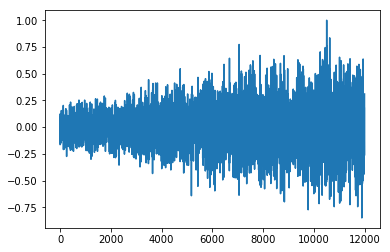

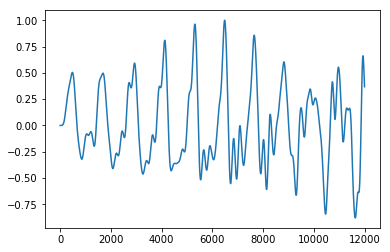

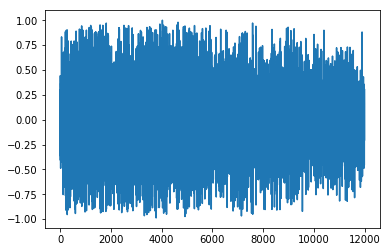

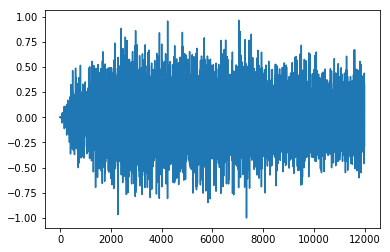

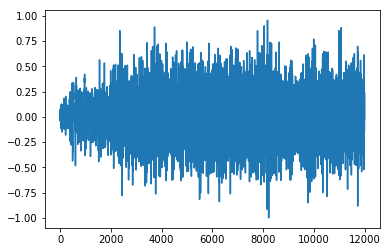

In [32]:
for i in range(5):
    plt.figure()
    plt.plot(crashes[i])

(1, 24)


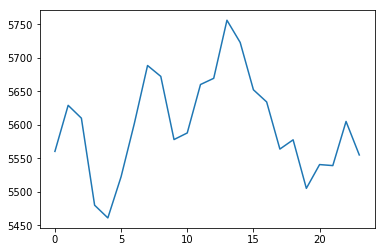

In [34]:
sr = 48000
crash = crashes[0]
kick = kicks[0]
centroid = librosa.feature.spectral_centroid(y=crash, sr=sr)
print(centroid.shape)
plt.figure()
plt.plot(centroid.T)

In [20]:
zero_crossing = librosa.feature.zero_crossing_rate(y=crash)
print(zero_crossing.shape)

(1, 24)


(1.0, -0.84964204)
(1, 24)


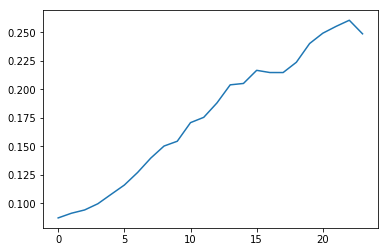

In [23]:
rms = librosa.feature.rmse(y=crash)
print(np.max(crash), np.min(crash))
print(rms.shape)
plt.figure()
plt.plot(rms.T)

In [24]:
spectral_contrast = librosa.feature.spectral_contrast(y=crash)
print(spectral_contrast.shape)

(7, 24)


(1, 24)


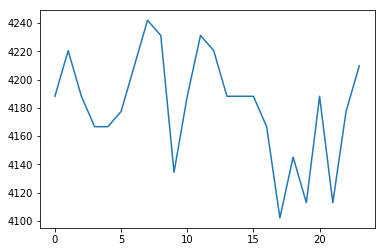

In [35]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=crash)
print(spectral_rolloff.shape)
plt.figure()
plt.plot(spectral_rolloff.T)

In [49]:
# Set hop_size=512 to make consistent with other spectral features
crash_fft = librosa.core.stft(crash, hop_length=512) 
print(crash_fft.shape)
numBlocks = crash_fft.shape[1]
print(numBlocks)
spectral_crest = np.zeros((1,numBlocks)
'''
for i in range(numBlocks):
    blockFFT = crash_fft[:,i]
    blockFFT = np.abs(blockFFT)
    spectral_crest[i] = np.max(blockFFT) / np.sum(blockFFT)
'''
    

SyntaxError: invalid syntax (<ipython-input-49-43a4998d0fb3>, line 12)

(1025, 24)
24


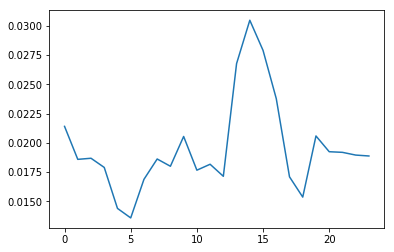

In [58]:
# Set hop_size=512 to make consistent with other spectral features
crash_fft = librosa.core.stft(crash, hop_length=512) 
crash_fft = np.abs(crash_fft)
print(crash_fft.shape)
numBlocks = crash_fft.shape[1]
print(numBlocks)
spectral_crest = np.zeros((1,numBlocks))
for i in range(numBlocks):
    blockFFT = crash_fft[:,i]
    spectral_crest[:,i] = np.max(blockFFT) / np.sum(blockFFT)                       

(1, 24)


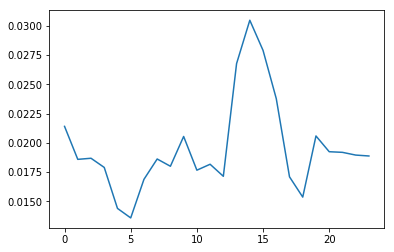

In [65]:
def computeSpectralCrest(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    numBlocks = sample_fft.shape[1]
    spectral_crest = np.zeros((1,numBlocks))
    for i in range(numBlocks):
        blockFFT = sample_fft[:,i]
        spectral_crest[:,i] = np.max(blockFFT) / np.sum(blockFFT)
    return spectral_crest

spectral_crest = computeSpectralCrest(crash)
print (spectral_crest.shape)
plt.figure()
plt.plot(spectral_crest.T)  

(1, 24)


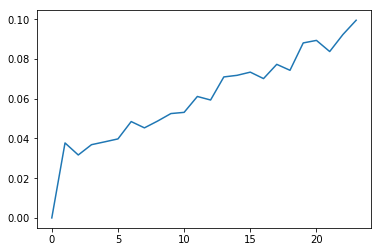

In [80]:
def computeSpectralFlux(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    (blockSize, numBlocks) = sample_fft.shape
    spectral_flux = np.zeros((1,numBlocks))
    spectral_flux[0] = 0 # Set flux at 0 for very first timestep
    
    for i in range(1,numBlocks):
        spectral_diff = sample_fft[:,i] - sample_fft[:,i-1]
        spectral_flux[:,i] = np.sqrt(np.sum(np.square(spectral_diff))) / (blockSize) # in MATLAB version we do blockSize/2 because MATLAB does not automatically halve and discard the spectrum for us
    
    return spectral_flux

spectral_flux = computeSpectralFlux(crash)
print (spectral_flux.shape)
plt.figure()
plt.plot(spectral_flux.T)  

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from utils import *
from os.path import join
from multiprocessing import Pool
import numpy as np
import itertools
import time as timeMod
from time import mktime
from datetime import datetime
import scipy.spatial
import scipy.spatial.distance as dist 
import python_speech_features as psf
import pickle
from skimage.measure import block_reduce

In [20]:
data_root = 'drumData/'
sr = 48000 # this is the samplerate initially used to load the samples
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))
drumMFCCs = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

CPU times: user 331 µs, sys: 233 ms, total: 233 ms
Wall time: 240 ms
CPU times: user 568 µs, sys: 13.3 ms, total: 13.8 ms
Wall time: 29.9 ms
CPU times: user 503 µs, sys: 128 ms, total: 129 ms
Wall time: 146 ms
CPU times: user 1.02 ms, sys: 30.6 ms, total: 31.6 ms
Wall time: 31.7 ms
CPU times: user 568 µs, sys: 6.98 ms, total: 7.55 ms
Wall time: 8.21 ms
CPU times: user 481 µs, sys: 5.82 ms, total: 6.3 ms
Wall time: 7.04 ms
CPU times: user 463 µs, sys: 14 ms, total: 14.4 ms
Wall time: 15.2 ms
